# __이미지로 이미지 검색하기__

**이미지 수치화 기술 이해하기**
---
👉이미지는 고차원 데이터(높이x너비x채널(RGB)x색의 강도)로써 각 픽셀의 정보를 무작위로 생성한다면 아무 의미를 갖지 않는 이미지가 생성됩니다. 즉, 각 픽셀은 주변 픽셀과 연관된 특정 패턴을 갖는 경우에만 사람이 이미지로 인식을 할 수 있게 됩니다. 이는 이미지를 실제보다 저차원적 특성 벡터에 표현할 수 있다는 의미입니다. 최근에는 인공지능을 이용해서 각 이미지가 갖는 의미의 유사도에 따라 저차원 공간에 수치화하여 표현하는 연구들이 다방면으로 이루어지고 있으며 이는 이미지 수치화, 벡터화(Vectorization), 임베딩(Embedding) 등의 이름으로 다양하게 활용되고 있습니다.

**본 튜토리얼에서는**
---
👉 이번 튜토리얼에서는 MNIST 손글씨 데이터 세트를 사용합니다. 각 이미지는 0~1 사이의 값을 갖는 고정 크기(28x28 = 784 픽셀) 이며, 여러 사람들이 손으로 쓴 0~9까지 숫자를 정답과 함께 제공합니다. 60,000 개의 학습용 데이터 세트와 10,000개의 테스트용 데이터 세트로 이루어져 있습니다.

ThanoSQL을 사용하여 손글씨 데이터를 입력하고 DB 내에서 입력 이미지와 유사한 이미지를 검색해주는 모델을 만들어 봅니다.

## __0. 데이터 세트 확인__

ThanoSQL의 쿼리 구문을 사용하기 위해서는 [ThanoSQL 워크스페이스](https://docs.thanosql.ai/quick_start/how_to_use_ThanoSQL/#5-thanosql)에서 언급된 것처럼 API 토큰을 생성하고 아래의 쿼리를 실행해야 합니다.

In [ ]:
%load_ext thanosql
%thanosql API_TOKEN=<발급받은 개인 토큰>

In [79]:
%%thanosql
COPY mnist_train FROM "tutorial_data/mnist_data/mnist_train.csv"

Success


In [80]:
%%thanosql
COPY mnist_test FROM "tutorial_data/mnist_data/mnist_test.csv"

Success


## __1. 데이터 세트 확인__

손글씨 분류 모델을 만들기 위해 ThanoSQL DB에 저장되어 있는 mnist_train 테이블을 사용합니다. mnist_train 테이블은 MNIST 이미지 파일들이 저장되어 있는 경로와 파일 이름 그리고 라벨 정보가 담겨 있는 테이블입니다. 아래의 쿼리문을 실행하고 테이블의 내용을 확인합니다.

In [81]:
%%thanosql
SELECT * 
FROM mnist_train 
LIMIT 5

,img_path,filename,label
0,tutorial_data/mnist_data/train/6782.jpg,6782.jpg,5
1,tutorial_data/mnist_data/train/1810.jpg,1810.jpg,5
2,tutorial_data/mnist_data/train/33617.jpg,33617.jpg,5
3,tutorial_data/mnist_data/train/27802.jpg,27802.jpg,5
4,tutorial_data/mnist_data/train/50677.jpg,50677.jpg,5


mnist_train 테이블은 아래와 같은 정보를 담고 있습니다. "6782.jpg" 이미지 파일은 숫자 5를 쓴 손글씨 이미지입니다.

- img_path: 이미지 경로
- filename: 파일 이름
- label : 이미지 라벨

## __2. 이미지 수치화 모델 생성__

이전 단계에서 확인한 mnist_train 테이블을 사용하여 이미지 수치화 모델을 만듭니다. 아래의 쿼리 구문을 실행하여 my_image_search_model이라는 이름의 모델을 만듭니다.  

(쿼리 실행 시 예상 소요 시간 : 1 min)

In [82]:
%%thanosql
BUILD MODEL my_image_search_model
USING SimCLR
OPTIONS (
    image_col='img_path',
    file_name='filename',
    max_epochs=1
    )
AS 
SELECT * 
FROM mnist_train

Success


__쿼리 세부 정보__ 
- "__BUILD MODEL__" 쿼리 구문을 사용하여 mnist_model 이라는 모델을 만들고 학습시킵니다.
- "__USING__" 쿼리 구문을 통해 베이스 모델로 SimCLR 모델을 사용할 것을 명시합니다.
- "__OPTIONS__" 쿼리 구문을 통해 모델 생성에 사용할 옵션을 지정합니다.  
    -  "image_col" : 데이터 테이블에서 이미지의 경로를 담은 컬럼 (Default : "path")
    -  "file_name" : 데이터 테이블에서 이미지 파일 이름을 담은 컬럼
    -  "max_epochs" : 이미지 수치화 모델을 생성하기 위한 데이터 세트 학습 횟수

아래 쿼리 구문을 사용하여 이미지 수치화 결과를 확인합니다. `my_image_search_model`을 "__CONVERT USING__" 쿼리 구문을 사용하여 `mnist_test` 이미지들을 임베딩합니다. 

In [83]:
%%thanosql
CONVERT USING my_image_search_model
OPTIONS(
    table_name= "mnist_test"
    )
AS 
SELECT * 
FROM mnist_test

,img_path,filename,label,my_image_search_model_simclr
0,tutorial_data/mnist_data/test/5099.jpg,5099.jpg,6,"[0.76583331823349, 0.5345810055732727, 0.43373..."
1,tutorial_data/mnist_data/test/9239.jpg,9239.jpg,6,"[0.7003944516181946, 0.34001582860946655, 0.42..."
2,tutorial_data/mnist_data/test/2242.jpg,2242.jpg,6,"[0.9108200669288635, 0.40680938959121704, 0.48..."
3,tutorial_data/mnist_data/test/3451.jpg,3451.jpg,6,"[0.9245117902755737, 0.5313209891319275, 0.351..."
4,tutorial_data/mnist_data/test/2631.jpg,2631.jpg,6,"[0.7445120811462402, 0.5756716728210449, 0.456..."
...,...,...,...,...
195,tutorial_data/mnist_data/test/8045.jpg,8045.jpg,8,"[0.6051712036132812, 0.35599127411842346, 0.40..."
196,tutorial_data/mnist_data/test/9591.jpg,9591.jpg,8,"[0.6837575435638428, 0.20702850818634033, 0.22..."
197,tutorial_data/mnist_data/test/7425.jpg,7425.jpg,8,"[0.722635805606842, 0.4351770579814911, 0.3241..."
198,tutorial_data/mnist_data/test/2150.jpg,2150.jpg,8,"[0.6432840824127197, 0.5282281041145325, 0.597..."


__쿼리 세부 정보__ 
- "__CONVERT USING__" 쿼리 구문은 `my_image_search_model`을 이미지 수치화를 위한 알고리즘으로 사용합니다.   
- "__OPTIONS__" 쿼리 구문을 통해 이미지 수치화 시 필요한 변수들을 정의합니다. 
    - "table_name" : ThanoSQL DB 내에 저장될 테이블 이름을 정의합니다. 

`mnist_test` 테이블에 `my_image_search_model_sinclr`이라는 컬럼을 새롭게 생성하고 수치화 결과를 저장합니다.

## __3. (이미지 폴더로부터) 이미지 수치화 결과 저장__

아래의 쿼리 구문을 실행하여 특정 폴더 내의 전체 이미지를 기존에 학습해 둔 모델을 사용해서 수치화 합니다. 위의 쿼리와 같은 역할을 하지만 학습을 위한 입력 데이터의 구조가 다릅니다.

In [84]:
%%thanosql
CREATE TABLE mnist_embds
USING my_image_search_model 
OPTIONS(
    path_type='folder', 
    data_type='image',
    file_type=['.jpg']
    ) 
FROM 'tutorial_data/mnist_data/test/'

Success


__쿼리 세부 정보__
- "__CREATE TABLEL__" 쿼리 구문을 사용하여 이미지 수치화 테이블(`mnist_embds`)을 만듭니다.  
- "__USING__"은 이미지 수치화에 사용할 모델을 정의합니다.
- "__OPTIONS__"는 이미지 수치화를 위한 이미지 파일의 속성값들을 정의합니다.
    - "path_type" :  데이터가 저장되어 있는 파일 경로의 타입(folder|file)  
    - "data_type" :  입력하는 비정형 데이터의 종류(image|audio|video)  
    - "file_type" : 대상 파일의 확장자   
- "__FROM__" 쿼리 구문을 사용하여 이미지 파일들이 들어있는 폴더의 경로를 적어줍니다.


아래 쿼리 구문을 사용하여 생성한 이미지 수치화 결과 테이블을 확인합니다.
각 이미지들마다 수치화 된 값들이 추가 되어있는 것을 확인할 수 있습니다.

In [85]:
%%thanosql
SELECT * 
FROM mnist_embds 
LIMIT 5

,image,my_image_search_model_simclr
0,tutorial_data/mnist_data/test/2778.jpg,"[0.6986842155456543, 0.37371528148651123, 0.16..."
1,tutorial_data/mnist_data/test/616.jpg,"[0.6745059490203857, 0.6385999321937561, 0.440..."
2,tutorial_data/mnist_data/test/1809.jpg,"[0.694808840751648, 0.5267070531845093, 0.5653..."
3,tutorial_data/mnist_data/test/5165.jpg,"[0.9796649813652039, 0.632573127746582, 0.7674..."
4,tutorial_data/mnist_data/test/8600.jpg,"[0.7320713996887207, 0.30531272292137146, 0.30..."


## __4. 이미지 수치화 모델을 사용해서 유사 이미지 검색하기__

이번 단계에서는 mnist_model 이미지 수치화 모델과 mnist_embds 수치화 테이블을 사용하여 "1.jpg" 이미지 파일(손글씨 0)과 유사한 이미지를 검색합니다.

In [86]:
%%thanosql
SEARCH IMAGE images='tutorial_data/mnist_data/train/1.jpg' 
USING my_image_search_model 
AS 
SELECT * 
FROM mnist_embds

,image,my_image_search_model_simclr,my_image_search_model_simclr_similarity1
0,tutorial_data/mnist_data/test/2778.jpg,"[0.6986842155456543, 0.37371528148651123, 0.16...",0.870745
1,tutorial_data/mnist_data/test/616.jpg,"[0.6745059490203857, 0.6385999321937561, 0.440...",0.877990
2,tutorial_data/mnist_data/test/1809.jpg,"[0.694808840751648, 0.5267070531845093, 0.5653...",0.875110
3,tutorial_data/mnist_data/test/5165.jpg,"[0.9796649813652039, 0.632573127746582, 0.7674...",0.876696
4,tutorial_data/mnist_data/test/8600.jpg,"[0.7320713996887207, 0.30531272292137146, 0.30...",0.863469
...,...,...,...
195,tutorial_data/mnist_data/test/4949.jpg,"[0.8542945981025696, 0.4021967649459839, 0.275...",0.886818
196,tutorial_data/mnist_data/test/6146.jpg,"[0.798995852470398, 0.4366079866886139, 0.3974...",0.889189
197,tutorial_data/mnist_data/test/2002.jpg,"[0.6420943737030029, 0.5466421246528625, 0.760...",0.883405
198,tutorial_data/mnist_data/test/4255.jpg,"[0.7085293531417847, 0.3245007395744324, 0.238...",0.877033


__쿼리 세부 정보__  

- "__SEARCH IMAGE [images|audio|videos]__" 쿼리 구문은 검색하고자 하는 이미지|오디오|비디오 파일을 정의합니다.  <br>
- "__USING__"은 이미지 수치화에 사용할 모델을 정의합니다.<br>
- "__AS__" 쿼리 구문은 검색에 사용할 임베딩 테이블을 정의합니다. `mnist_embds` 테이블을 사용합니다 

다음 쿼리를 실행하여 "__SEARCH__" 결과를 ThanoSQL의 "__PRINT__" 쿼리 구문을 활용하여 가장 유사한 상위 4개를 출력합니다. 학습을 조금 밖에 진행하지 않았지만 6과 비슷한 이미지를 출력하는 것을 확인할 수 있습니다.

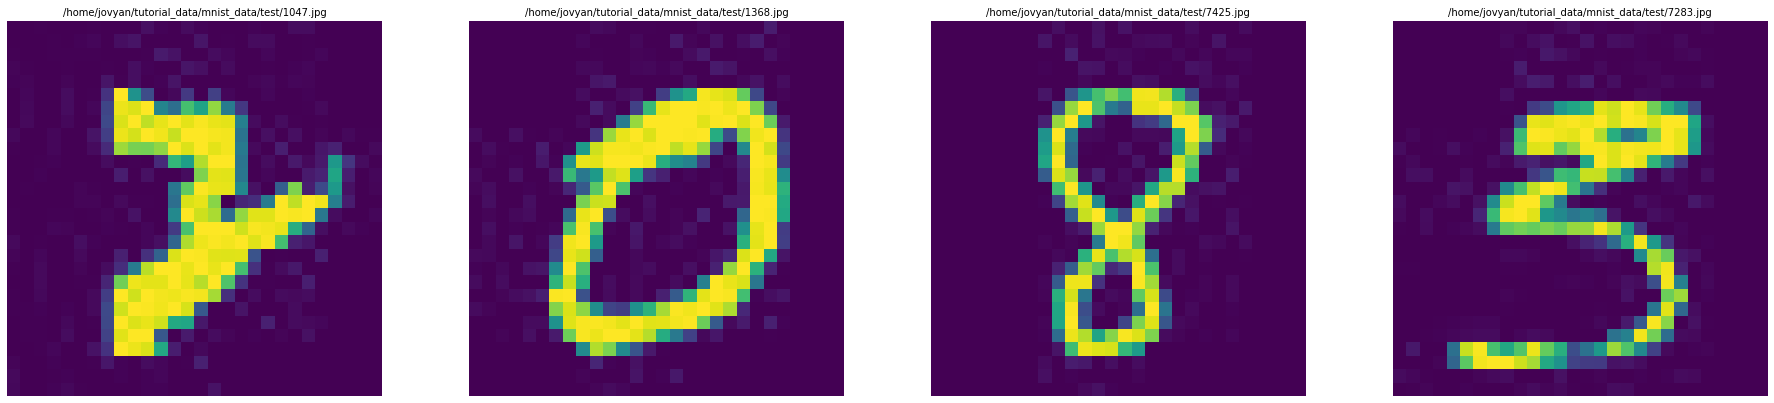

In [87]:
%%thanosql
PRINT IMAGE 
AS (
    SELECT image 
    AS image, my_image_search_model_simclr_similarity1 
    FROM (
        SEARCH IMAGE images='tutorial_data/mnist_data/train/1.jpg'
        USING my_image_search_model 
        AS 
        SELECT * 
        FROM mnist_embds
        )
    ORDER BY my_image_search_model_simclr_similarity1 DESC 
    LIMIT 4
    )

__참고 사항__ 

이미지 유사도 검색 알고리즘의 기본 학습 옵션은 이미지의 좌우상하 반전, 색상의 변화 등에 관계없이 모두 같은 이미지로 인식하도록 학습이 진행 됩니다. 강아지의 사진은 뒤집히거나 색이 변해도 강아지로 인식되어야 하기 때문입니다. 의류 이미지 등과 같이 색의 변화가 중요하거나 숫자 처럼 상하, 좌우 반전이 중요한 경우 학습 시 옵션을 변경해 주어야 합니다. 본 튜토리얼에서는 이러한 이미지 유사도 검색의 특징을 보여주고 있습니다.